<b>Please install the following libraries to run this project:</b>

In [1]:
#pip install ipython-sql
#pip install mysqlclient
#pip install mysql-connector-python
#pip install pymysql
#pip install vaderSentiment
#pip install -U textblob
#pip install skforecast --user

<b>Library Importation</b>

In [31]:
import numpy as np              
import pandas as pd             
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns  # library for making statistical graphics in Python.
from datetime import timedelta

import mysql.connector
import pymysql

from pyspark.sql import SparkSession

# Load vaderSentimental library
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

from joblib import dump, load


import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Create and initialise an object
sentiment = SentimentIntensityAnalyzer()

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
#from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

import itertools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose


[nltk_data] Downloading package stopwords to /home/hduser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<b>Mysql Connection:</b>

Please intall the my sql connector version 8.1.0

PLEASE, RUN THE COMMANDS BELOW ON TERMINAL TO CREATE AND GRANT PERMISSIONS TO user1:
<br/>
<br/>
mysql -u root -p
<br/>
CREATE USER 'user1'@'%%' IDENTIFIED BY 'Pass@word1';
<br/>
GRANT ALL PRIVILEGES ON * . * TO 'Pass@word1'@'%%';
<br/>
FLUSH PRIVILEGES;
<br/>

In [5]:
# Creating a connection to the mySQL database 
connMySQL = pymysql.connect(host = 'localhost',
                             user = 'user1',
                             password = 'Pass@word1',
                             db = 'dbTwitter')

cursor = connMySQL.cursor()

<b>Global Variables:</b>

In [15]:
# Path to data set
csv_file = "file:///home/hduser/Downloads/work2/ProjectTweets.csv"

In [18]:
# Parameters below will be used to beautify the graphs

# Define the graph style
plt.style.use("seaborn-whitegrid");

# define size and autolayout
# Autolayout: the graph will fit automaticaly on the screen resoltion
plt.rc("figure", autolayout=True, figsize=(11, 4));

# Defining axes atributes of the graph 
plt.rc(
    "axes",
    labelweight = "bold",
    labelsize = "large",
    titleweight = "bold",
    titlesize = 14,
    titlepad = 10,
);
# Defining axes atributes of the graph 
plot_params = dict(
    color = "0.75",
    style = ".-",
    markeredgecolor = "0.25",
    markerfacecolor = "0.25",
    legend = False,
);

# Command to autoformat date axis
plt.gcf().autofmt_xdate();

# format the graph as retina style
#%config InlineBackend.figure_format = 'retina';

<Figure size 1100x400 with 0 Axes>

# Data Understanding - Part 1

<b>Creating a new spark session and load CSV data to a temporary spark table and to a spark dataframe: </b>

In [16]:
# Create a SparkSession
spark = (SparkSession
  .builder
  .appName("SparkSQL")
  .getOrCreate())

# Read and create a temporary view
# The dataset doesnt contain header, so header = false
# toDF to define appropriated column name
dfTwitter = (spark.read.format("csv")
  .option("inferSchema", "true")
  .option("header", "false")
  .load(csv_file)
  .toDF('id', 'seq', 'date', 'query', 'user', 'tweet'))

dfTwitter.createOrReplaceTempView("tblTempTwitter")


<b>Printing some records to take a first look on the dataset:</b>

In [17]:
spark.sql("""SELECT * FROM tblTempTwitter""").show(10)

+---+----------+--------------------+--------+---------------+--------------------+
| id|       seq|                date|   query|           user|               tweet|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|  5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|  6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|  7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|  8|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nop

In [18]:
spark.sql("""SELECT * FROM tblTempTwitter where query != 'NO_QUERY'""").show(10)

+---+---+----+-----+----+-----+
| id|seq|date|query|user|tweet|
+---+---+----+-----+----+-----+
+---+---+----+-----+----+-----+



In [19]:
spark.sql("""SELECT user, COUNT(user) as total FROM tblTempTwitter GROUP BY user ORDER BY total desc;""").show(20)



+---------------+-----+
|           user|total|
+---------------+-----+
|       lost_dog|  549|
|        webwoke|  345|
|       tweetpet|  310|
|SallytheShizzle|  281|
|    VioletsCRUK|  279|
|    mcraddictal|  276|
|       tsarnick|  248|
|    what_bugs_u|  246|
|    Karen230683|  238|
|      DarkPiano|  236|
|   SongoftheOss|  227|
|      Jayme1988|  225|
|         keza34|  219|
| ramdomthoughts|  216|
|      shanajaca|  213|
|         wowlew|  212|
|     nuttychris|  211|
|   TraceyHewins|  211|
|   thisgoeshere|  207|
|     Spidersamm|  205|
+---------------+-----+
only showing top 20 rows



Looking for null or blank date values

In [20]:
spark.sql("""SELECT user, tweet FROM tblTempTwitter where date is null or date =='';""").show(20)


+----+-----+
|user|tweet|
+----+-----+
+----+-----+



# Data Preparation

## SPARK HIVE

Creating a Database, table and proccessing data in Hive Metastore. 
<br/>
<b>Database name:</b> dbTwitter
<br/>
<b>Table name:</b> tblTwitter
<br/>
<b>Operation:</b> Store the CSV file in a permanent table in HIVE (Spark). This hive table will be used as a performance comparation with MySQL
<br/>


In [22]:
#Creating a Database dbTwitter in Hive
spark.sql("CREATE DATABASE IF NOT EXISTS dbTwitter")



2023-10-18 09:50:42,644 WARN conf.HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
2023-10-18 09:50:42,646 WARN conf.HiveConf: HiveConf of name hive.stats.retries.wait does not exist
2023-10-18 09:50:46,798 WARN metastore.ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
2023-10-18 09:50:46,798 WARN metastore.ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore hduser@127.0.1.1
2023-10-18 09:50:47,225 WARN metastore.ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
2023-10-18 09:50:47,242 ERROR metastore.RetryingHMSHandler: AlreadyExistsException(message:Database dbtwitter already exists)
	at org.apache.hadoop.hive.metastore.HiveMetaStore$HMSHandler.create_database(HiveMetaStore.java:925)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeM

DataFrame[]

Using spark.sql() method "CREATE TABLE" to create a table in Hive from the spark temporary view tblTempTwitter.

In [23]:
#Create a Table in Hive tblTwitter on the bdTwitter database.
spark.sql("CREATE TABLE IF NOT EXISTS dbTwitter.tblTwitter (id Int, seq Double, date String, query String, user String, tweet String)")



2023-10-18 09:50:55,618 WARN analysis.ResolveSessionCatalog: A Hive serde table will be created as there is no table provider specified. You can set spark.sql.legacy.createHiveTableByDefault to false so that native data source table will be created instead.
2023-10-18 09:50:56,236 WARN session.SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
2023-10-18 09:50:56,471 WARN conf.HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
2023-10-18 09:50:56,471 WARN conf.HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
2023-10-18 09:50:56,472 WARN conf.HiveConf: HiveConf of name hive.stats.retries.wait does not exist
2023-10-18 09:50:56,529 ERROR metastore.RetryingHMSHandler: AlreadyExistsException(message:Table tbltwitter already exists)
	at org.apache.hadoop.hive.metastore.HiveMetaStore$HMSHandler.create_table_core(HiveMetaStore.java:1416)
	at org.apach

DataFrame[]

Inserting data from the spark temporary view tblTempTwitter into the Hive table tblTwitter:

In [29]:
#query to test if the table has rows, if has is because the code is been processed again and we do not need to reproccess
query = spark.sql("Select * from dbTwitter.tblTwitter LIMIT 1;")

#Test if the table is empty
if not query:
    #If the table is empty, them execute the code to fill with the dataset data
    #Insert into Hive tblTwitter using the spar temp view tblTempTwitter. 
    spark.sql("INSERT INTO TABLE dbTwitter.tblTwitter SELECT * FROM tblTempTwitter")    
else:
    print("Table is not empty!")


Table is not empty!


In [26]:
#Lets view the data in the hive table
spark.sql("SELECT * FROM dbTwitter.tblTwitter").show(10)

+------+-------------+--------------------+--------+---------------+--------------------+
|    id|          seq|                date|   query|           user|               tweet|
+------+-------------+--------------------+--------+---------------+--------------------+
|545133|2.201337104E9|Tue Jun 16 20:08:...|NO_QUERY|      alt_ducky|@miss_clariss oh ...|
|545134|2.201337108E9|Tue Jun 16 20:08:...|NO_QUERY|     CourtneyVR|Failed my WOF. Wi...|
|545135|2.201337287E9|Tue Jun 16 20:08:...|NO_QUERY|    melissaholt|Watching the firs...|
|545136|2.201337425E9|Tue Jun 16 20:08:...|NO_QUERY|       itznesha|my computer is in...|
|545137|2.201337512E9|Tue Jun 16 20:08:...|NO_QUERY|    lovinmyboys|Worked out my upp...|
|545138|2.201337757E9|Tue Jun 16 20:08:...|NO_QUERY|     mikerbrant|OMG I got my new ...|
|545139|2.201338077E9|Tue Jun 16 20:08:...|NO_QUERY|         daulex|my back has flare...|
|545140|2.201338113E9|Tue Jun 16 20:08:...|NO_QUERY|    CaliHeather|I am starting to ...|
|545141|2.

## MySQL

Creating a Database, tables and proccess data with MySQL
<br/>
<b>Database name:</b> dbTwitter
<br/>
<b>Table names:</b> tblTwitter, tblTwitterPrep
<br/>
<b>Details:</b> 
<br/>
MySQL is used to do the Data Preparation in this project.
<br/>
New tables were created, new features, data transformation, and all necessary steps to prepare the data to be fit on the forecast model.

<b>Creating a new database and the first table on MySQL:</b>

In [32]:

#Creating a new database if not exists
cursor.execute("CREATE DATABASE IF NOT EXISTS dbTwitter;")
#Use the dbTwitter in the context
cursor.execute("USE dbTwitter;")

#Creating a new table if not exists
cursor.execute("CREATE TABLE IF NOT EXISTS dbTwitter.tblTwitter (id NUMERIC, seq NUMERIC, date VARCHAR(50), query VARCHAR(50), user VARCHAR(50), tweet TEXT)")

0

<b>Copy the data from Hive table to the correspondent table in MySQL: </b>

In [13]:
#COPY the data from HIVE table to My SQL table

query = connMySQL.query('SELECT id FROM dbTwitter.tblTwitter LIMIT 1;')

#Test if the table is empty
if not query:
    # convert the spark dataframe to pandas dataframe to iterate 
    dfPandasTwitter = dfTwitter.toPandas()
    
    #If the table is empty, them execute the code to fill with the dataset data
    # reading the columns to use on the insert clause
    cols = ",".join([str(i) for i in dfPandasTwitter.columns.tolist()])

    # Insert on the mySQL table all records from SPark SQL
    for i, row in dfPandasTwitter.iterrows():
        sql = "INSERT INTO tblTwitter (" + cols + ") VALUES (" + "%s," * (len(row) - 1) + "%s)"
        cursor.execute(sql, tuple(row))
        
        # the connection is not autocommitted by default, so commit command is necessary to save the changes
        connMySQL.commit()
else:
    print ("This table is not empty!")



This table is not empty!


<b>Creating a new table with the new necessary features:</b>
<br/>
<br/>
The idea is keeping the original table to be used in the performance comparision, all the data preparation will be processed in this new table.
<br/>
<br/>
<b>New features:</b>
<li>date_custom: Date</li>
<li>week: Char(3)</li>
<li>hour: Int</li>
<li>minute: Int</li>
<li>second: Int</li>
<li>day: Int</li>
<li>month: Int</li>
<li>year: Int</li>
<li>sentiment: Double</li>

In [9]:
# Creating the new table to start the data preparation
# It was excluded 
cursor.execute("""CREATE TABLE IF NOT EXISTS dbTwitter.tblTwitterPreparation (
                id Int, 
                date VARCHAR(50), 
                user VARCHAR(50),                 
                tweet TEXT, 
                tweet_review TEXT, 
                date_custom Date,
                week CHAR(3), 
                hour Int, 
                minute Int, 
                second Int, 
                day Int, 
                month Int, 
                year Int, 
                sentiment_vader Double,
                sentiment_blob Double,
                INDEX (id))
              """)

connMySQL.commit()

In [10]:

#cursor.execute("DROP TABLE dbTwitter.tblTwitterPreparation;")
#connMySQL.commit()

<b>Inserting data to the Data Preparation table (tblTwitterPrep) transforming data during the proccess:</b>
<br/>
<br/>
Substring function is used to split the original date value to separeted columns like day, year, hour... These columns can be usefull to plot graphs or to fit in the Machine Learning models.
<br/>
Switch case is used to transform the text value of month (apr, may, jun) into a number value (4, 5 ,6).
<br/>
a DD/MM/YYYY will be processed after this step.
<br/>
<br/>
<b>Original date format:</b> Mon Apr 06 22:19:45 PDT 2009	
<br/>
.

In [11]:
query = connMySQL.query('SELECT id FROM dbTwitter.tblTwitterPreparation LIMIT 1;')

#Test if the table is empty
if not query:
    #If the table is empty, them execute the code to fill with the dataset data    
    
    cursor.execute("""INSERT INTO dbTwitter.tblTwitterPreparation 
                  (id, date, user, tweet, 
                  tweet_review, date_custom, 
                  week, hour, minute, second, 
                  day, month, year, sentiment_vader, sentiment_blob)
                  SELECT id, 
                  date, 
                  user, 
                  tweet,
                  NULL,
                  NULL,
                  SUBSTR(date, 1, 3), 
                  SUBSTR(date, 12, 2), 
                  SUBSTR(date, 15, 2),                    
                  SUBSTR(date, 18, 2),                                      
                  SUBSTR(date, 9, 2),                                                        
                  CASE SUBSTR(date, 5, 3)                      
                      WHEN 'apr' THEN 4
                      WHEN 'may' THEN 5
                      WHEN 'jun' THEN 6                      
                      ELSE NULL
                  END,   
                  SUBSTR(date, 25, 4),                                                                          
                  0.0,  
                  0.0
                  FROM dbTwitter.tblTwitter;""")   
    
    connMySQL.commit()
    
else:
    print("Table is not empty!")



<b>Creating a YYYY/MM/DD date value:</b>

In [12]:

sql = """UPDATE dbTwitter.tblTwitterPreparation t1, dbTwitter.tblTwitterPreparation t2 
SET t1.date_custom = STR_TO_DATE( 
         CONCAT( t2.day, '/', t2.month, '/', t2.year ), '%d/%m/%Y')
WHERE t1.id = t2.id"""

cursor.execute(sql)

connMySQL.commit()

 - a positive sentiment, compound ≥ 0.05.
 - a negative sentiment, compound ≤ -0.05.
 - a neutral sentiment, the compound is between ]-0.05, 0.05[


In [ ]:

#df_Sentimental_Analysis.at[i,'compound'] = sent['compound']
#if float(sent['compound']) >= 0.05:
#    df_Sentimental_Analysis.at[i,'sentiment'] = 'positive'
#    positive += 1
#elif float(sent['compound']) <= -0.05:
#    df_Sentimental_Analysis.at[i,'sentiment'] = 'negative'
#    negative += 1
#else:
#    df_Sentimental_Analysis.at[i,'sentiment'] = 'neutral'
#    neutral += 1

#### Calculating the sentiment (Vader and Blob)

Each tweet will have the text sentiment calculated using Vader and Blob.
<br/>
This is an step to prepare the data for forecasting.
<br/>
<br/>
<b><span style="color:red">I strongly do not recommend </span>to run the vader and blob calculation step below. Even using index to tunning the table, this step took more than one hour to be processed. Instead you can restore the database backup submitted.



In [4]:
def get_text_processing(text):
    stpword = stopwords.words('english')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

#stop = stopwords.words('english')

#print(get_text_processing("This bad, is a: test; for' the stop wonderful words function, try again, the a an if this those work!"))

#testimonial = TextBlob(get_text_processing("This bad is a test for the stop wonderful words function, try again, the a an if this those work!"))
#print(testimonial.sentiment)
#print(testimonial.sentiment[0])

In [5]:
#Loading all the rows to be proccessed with the sentiment
dfTweets = pd.read_sql(sql = "select id, tweet from dbTwitter.tblTwitterPreparation", con = connMySQL)


In [6]:
#Loading all the rows to be proccessed with the sentiment
#dfTweets = pd.read_sql(sql = "select id, tweet from dbTwitter.tblTwitterPreparation", con = connMySQL)

#Iterate on the dataset to calculate the sentiment of each tweet and store on the database
for i, row in dfTweets.iterrows():

    tweet_reviewed = get_text_processing(row["tweet"])
    #tweet_reviewed = tweet_reviewed.replace("'", "")
    #tweet_reviewed = tweet_reviewed.replace('"', '')
        
    #print("tweet_reviewed: " + tweet_reviewed)
        
    #Calculate the sentiment
    sent_vader = sentiment.polarity_scores(tweet_reviewed)['compound']
    sent_blob = TextBlob(tweet_reviewed).sentiment[0]
    
    sql = "UPDATE dbTwitter.tblTwitterPreparation SET "
    sql += "sentiment_vader = " + str(sent_vader) + ", "
    sql += "sentiment_blob = " + str(sent_blob) + ", "
    sql += "tweet_review = '" + str(tweet_reviewed) + "' "
    sql += " WHERE id = " + str(row["id"]) + ";"
    
    #print("sql: " + sql)
    
    #print("id: " + str(row["id"]))

    cursor.execute(sql)    
    # the connection is not autocommitted by default, so commit command is necessary to save the changes
    connMySQL.commit()
    
    #break

    

# Data Understanding - Part 2

Having the original date value splitted in different columns will allow to performing better analysis on the data quality.
<br/>
Group by clauses are now possible (or at least easier) to be performed and some analysis can be prepared, like:
<li>Searching for missing tweets per day</li>
<li>Searching for missing tweets per hour</li>
<li>Analysing the weight difference between days/months</li>

### Average sentiment per day

In [31]:
sql1 = """SELECT CONVERT(date_custom, DATE) as date, 
                AVG(sentiment_vader) as sentiment_vader, 
                AVG(sentiment_blob) as sentiment_blob
FROM dbTwitter.tblTwitterPreparation
GROUP BY CONVERT(date_custom, DATE)
ORDER BY CONVERT(date_custom, DATE)"""

dfTweetsPredict1 = pd.read_sql(sql = sql1, con = connMySQL)

#sql2 = """SELECT DATE(date_custom) as date, AVG(sentiment) as sentiment
#FROM dbTwitter.tblTwitterPreparation
#WHERE sentiment != 0
#GROUP BY date_custom
#ORDER BY date_custom"""

#dfTweetsPredict2 = pd.read_sql(sql = sql2, con = connMySQL)


In [32]:

dfTweetsPredict1

,date,sentiment_vader,sentiment_blob
0,2009-04-06,0.155006,0.094019
1,2009-04-07,0.170903,0.099391
2,2009-04-17,0.208811,0.121702
3,2009-04-18,0.186284,0.112139
4,2009-04-19,0.191934,0.114881
5,2009-04-20,0.183340,0.111665
6,2009-04-21,0.182650,0.109819
7,2009-05-01,0.184256,0.111823
8,2009-05-02,0.186152,0.114778
9,2009-05-03,0.178122,0.108815


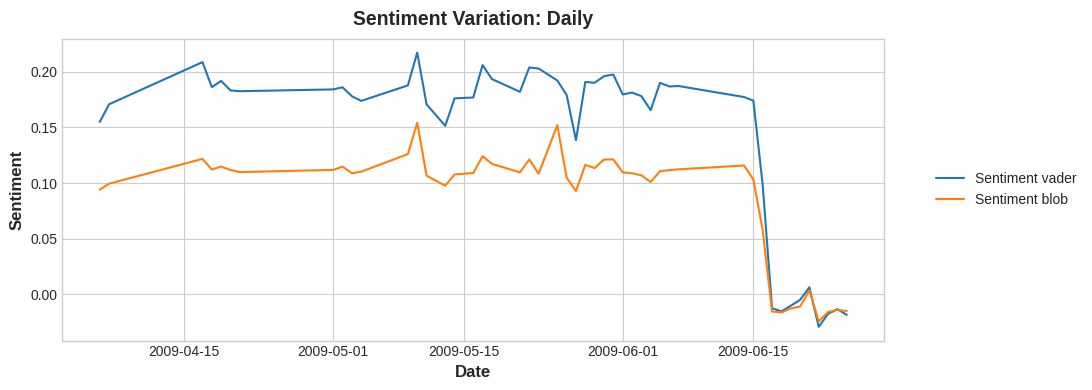

In [33]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots();

# Ploting graph lines
ax.plot(dfTweetsPredict1['date'], dfTweetsPredict1['sentiment_vader'], label='Sentiment vader');  # Plot first line of data.
ax.plot(dfTweetsPredict1['date'], dfTweetsPredict1['sentiment_blob'], label='Sentiment blob');  # Plot second line of data

ax.set_xlabel('Date');  # Add an x-label to the axes.
ax.set_ylabel('Sentiment');  # Add a y-label to the axes.

ax.set_title("Sentiment Variation: Daily");  # Add a title to the graph.
ax.legend(loc="right", bbox_to_anchor=(1.25, 0.5)) #Better positioning the legend

### Average Sentiment per hour

In [34]:
sql2 = """SELECT DATE_FORMAT(concat(year, '/', month, '/', day, ' ', hour, ':', '00'), '%Y/%m/%d %H:%i') as date, 
        AVG(sentiment_vader) as sentiment_vader,
        AVG(sentiment_blob) as sentiment_blob
FROM dbTwitter.tblTwitterPreparation
GROUP BY DATE_FORMAT(concat(year, '/', month, '/', day, ' ', hour, ':', '00'), '%Y/%m/%d %H:%i')
ORDER BY DATE_FORMAT(concat(year, '/', month, '/', day, ' ', hour, ':', '00'), '%Y/%m/%d %H:%i')"""

dfTweetsPredict2 = pd.read_sql(sql = sql2, con = connMySQL)


In [35]:
pd.set_option('display.max_rows', None)

dfTweetsPredict2

,date,sentiment_vader,sentiment_blob
0,2009/04/06 22:00,0.143017,0.085042
1,2009/04/06 23:00,0.163088,0.100071
2,2009/04/07 00:00,0.175061,0.103789
3,2009/04/07 01:00,0.170414,0.105734
4,2009/04/07 02:00,0.181674,0.102587
5,2009/04/07 03:00,0.168963,0.099639
6,2009/04/07 04:00,0.172308,0.105800
7,2009/04/07 05:00,0.165456,0.091903
8,2009/04/07 06:00,0.171277,0.098949
9,2009/04/07 07:00,0.167515,0.086663


<Figure size 1100x400 with 0 Axes>

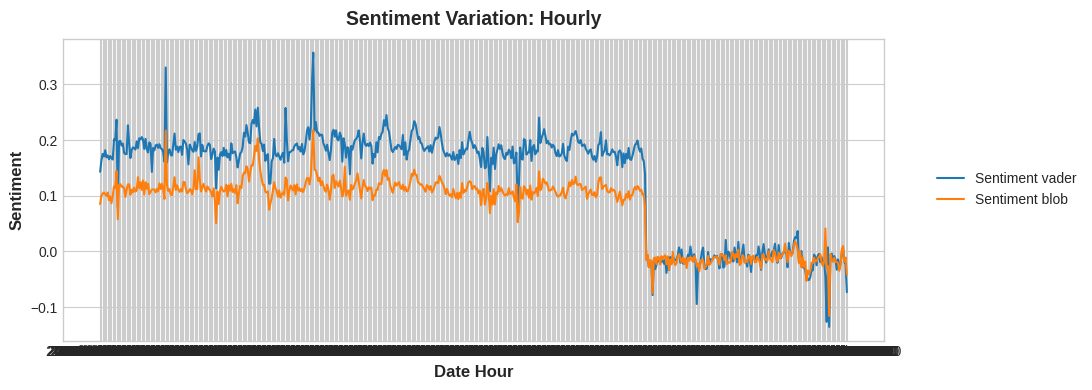

In [36]:

# Command to autoformat date axis
plt.gcf().autofmt_xdate();

# create figure and axis objects with subplots()
fig, ax = plt.subplots();

# Ploting graph lines
ax.plot(dfTweetsPredict2['date'], dfTweetsPredict2['sentiment_vader'], label='Sentiment vader');  # Plot first line of data.
ax.plot(dfTweetsPredict2['date'], dfTweetsPredict2['sentiment_blob'], label='Sentiment blob');  # Plot second line of data

ax.set_xlabel('Date Hour');  # Add an x-label to the axes.
ax.set_ylabel('Sentiment');  # Add a y-label to the axes.

ax.set_title("Sentiment Variation: Hourly");  # Add a title to the graph.
ax.legend(loc="right", bbox_to_anchor=(1.25, 0.5)) #Better positioning the legend

### Average Sentiment per day - Only last hour (23:00)

In [37]:
sql3 = """SELECT date_custom as date, 
                AVG(sentiment_vader) as sentiment_vader, 
                AVG(sentiment_blob) as sentiment_blob
FROM dbTwitter.tblTwitterPreparation
WHERE hour = 23
GROUP BY date_custom
ORDER BY date_custom"""

dfTweetsPredict3 = pd.read_sql(sql = sql3, con = connMySQL)



In [38]:
dfTweetsPredict3

,date,sentiment_vader,sentiment_blob
0,2009-04-06,0.163088,0.100071
1,2009-04-18,0.185251,0.114516
2,2009-04-19,0.181441,0.110693
3,2009-04-20,0.178800,0.108793
4,2009-05-01,0.187770,0.107055
5,2009-05-02,0.170637,0.107639
6,2009-05-03,0.168804,0.098976
7,2009-05-09,0.206306,0.140452
8,2009-05-11,0.174763,0.107772
9,2009-05-13,0.167412,0.109247


<Figure size 1100x400 with 0 Axes>

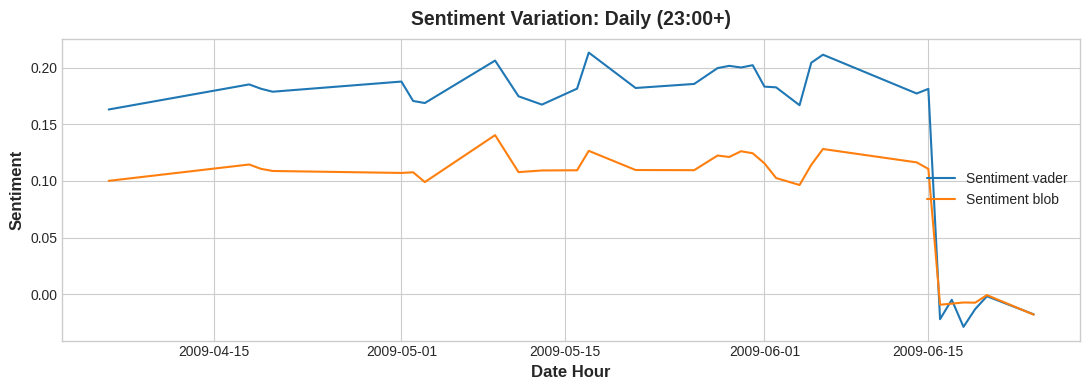

In [39]:

# Command to autoformat date axis
plt.gcf().autofmt_xdate();

# create figure and axis objects with subplots()
fig, ax = plt.subplots();

# Ploting graph lines
ax.plot(dfTweetsPredict3['date'], dfTweetsPredict3['sentiment_vader'], label='Sentiment vader');  # Plot first line of data.
ax.plot(dfTweetsPredict3['date'], dfTweetsPredict3['sentiment_blob'], label='Sentiment blob');  # Plot second line of data

ax.set_xlabel('Date Hour');  # Add an x-label to the axes.
ax.set_ylabel('Sentiment');  # Add a y-label to the axes.

ax.set_title("Sentiment Variation: Daily (23:00+)");  # Add a title to the graph.
ax.legend(loc="right", bbox_to_anchor=(1, 0.5)) #Better positioning the legend

### Average sentiment per day - Textblob Comparative with/without 0 values

In [40]:
sql4 = """SELECT CONVERT(date_custom, DATE) as date, 
                AVG(sentiment_blob) as sentiment_blob                
FROM dbTwitter.tblTwitterPreparation
WHERE sentiment_blob != 0
GROUP BY CONVERT(date_custom, DATE)
ORDER BY CONVERT(date_custom, DATE)"""

dfTweetsPredict4 = pd.read_sql(sql = sql4, con = connMySQL)


sql44 = """SELECT CONVERT(date_custom, DATE) as date,                 
                AVG(sentiment_blob) as sentiment_blob
FROM dbTwitter.tblTwitterPreparation
GROUP BY CONVERT(date_custom, DATE)
ORDER BY CONVERT(date_custom, DATE)"""

dfTweetsPredict44 = pd.read_sql(sql = sql44, con = connMySQL)

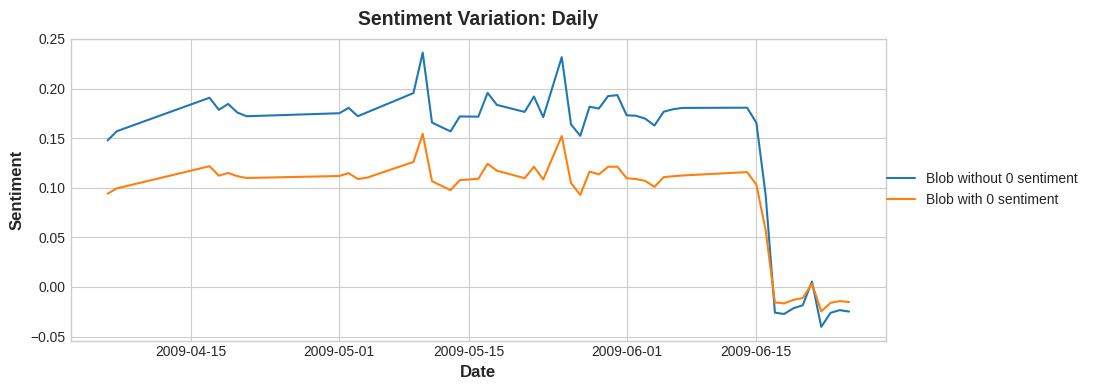

In [42]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots();

# Ploting graph lines
ax.plot(dfTweetsPredict4['date'], dfTweetsPredict4['sentiment_blob'], label='Blob without 0 sentiment');  # Plot first line of data.
ax.plot(dfTweetsPredict44['date'], dfTweetsPredict44['sentiment_blob'], label='Blob with 0 sentiment');  # Plot second line of data

ax.set_xlabel('Date');  # Add an x-label to the axes.
ax.set_ylabel('Sentiment');  # Add a y-label to the axes.

ax.set_title("Sentiment Variation: Daily");  # Add a title to the graph.
ax.legend(loc="right", bbox_to_anchor=(1.25, 0.5)) #Better positioning the legend

# Data Preparation - Part 2

In [186]:
sqlPrep = """SELECT CONVERT(date_custom, DATE) as date, 
                week,
                AVG(sentiment_blob) as sentiment_blob
FROM dbTwitter.tblTwitterPreparation
WHERE sentiment_blob != 0
GROUP BY CONVERT(date_custom, DATE), week
ORDER BY CONVERT(date_custom, DATE), week"""


dfTweetsPrep = pd.read_sql(sql = sqlPrep, con = connMySQL)

#dfTweetsPrep.head()

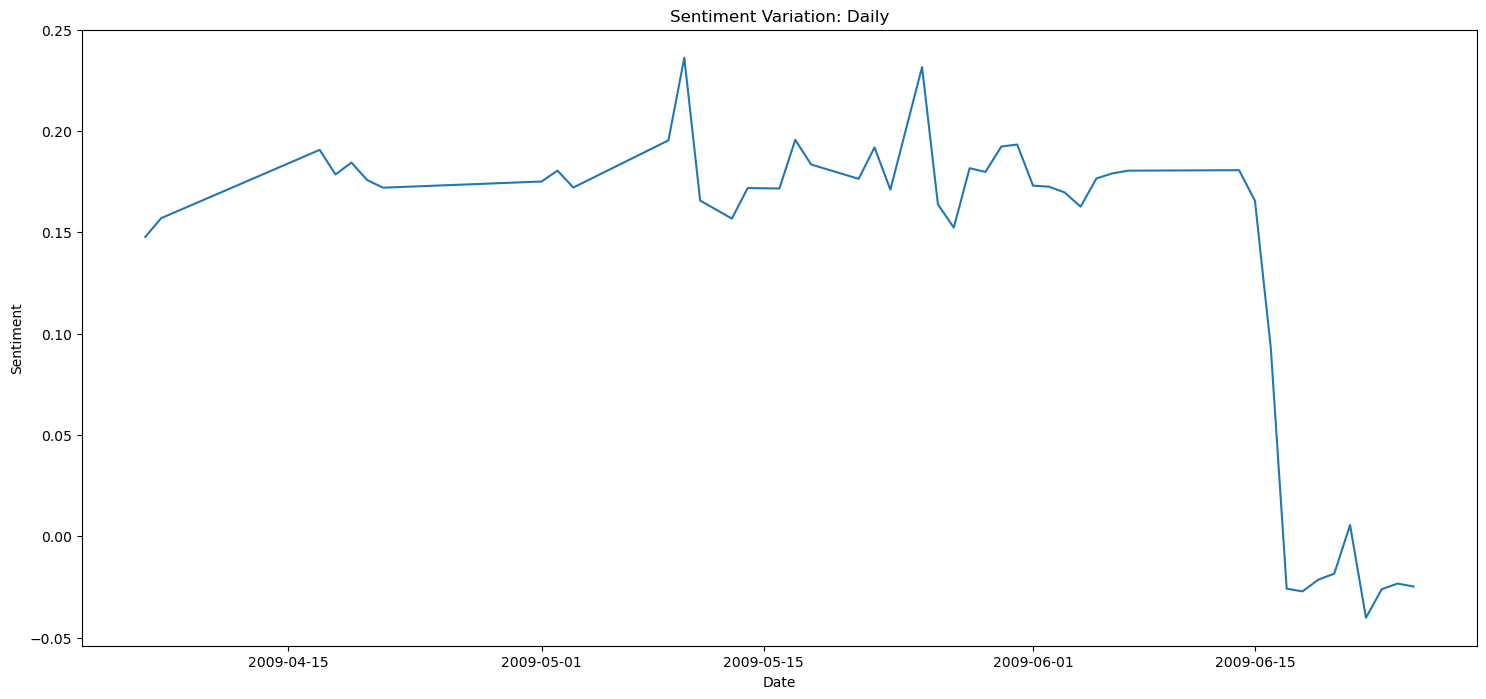

In [187]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots();

# Ploting graph lines
ax.plot(dfTweetsPrep['date'], dfTweetsPrep['sentiment_blob'], label='Blob sentiment');  # Plot first line of data.

ax.set_xlabel('Date');  # Add an x-label to the axes.
ax.set_ylabel('Sentiment');  # Add a y-label to the axes.

ax.set_title("Sentiment Variation: Daily");  # Add a title to the graph.

In [188]:
def fInserRow(pDate, pWeek, pSent, df):
    new_row = {'date': pDate, 'week': pWeek, 'sentiment_blob': pSent }
    df = df.append(new_row, ignore_index = True)
    return df


In [189]:
bWithAprilData = True

if bWithAprilData :
    #with april values
    dfTweetsPrep = dfTweetsPrep.drop(index=[36,37,38,39,40,41,42,43,44,45,46,47])
else:
    # without april and june
    dfTweetsPrep = dfTweetsPrep.drop(index=[0,1,2,3,4,5,6,7,8,9,36,37,38,39,40,41,42,43,44,45,46,47])

    
# 2009-05-24 value
dfTweetsPrep = fInserRow('2009-05-24', 'Sun', 0.24, dfTweetsPrep)

# 2009-05-19 value
# to calculate 2009-05-19 value, lets calculate the decrease percentage of change from the 2 values before and apply the same difference
percent = (dfTweetsPrep.iloc[17, 2] * 100 / dfTweetsPrep.iloc[18, 2]) - 100
sent = dfTweetsPrep.iloc[18, 2] - (dfTweetsPrep.iloc[18, 2] * (percent / 100))
dfTweetsPrep = fInserRow('2009-05-19', 'Tue', sent, dfTweetsPrep)

# 2009-05-20 value
# to calculate 2009-05-20 value, lets calculate the decrease percentage of change from the 2 values before and apply the same difference
# same percent before
sent = sent - (sent * (percent / 100))
dfTweetsPrep = fInserRow('2009-05-20', 'Wed', sent, dfTweetsPrep)

# 2009-05-15 value
# to calculate 2009-05-15 value, lets calculate the average pair values
sent = (dfTweetsPrep.iloc[16, 2] + dfTweetsPrep.iloc[14, 2]) / 2
dfTweetsPrep = fInserRow('2009-05-15', 'Fri', sent, dfTweetsPrep)

# 2009-05-12 value
# to calculate 2009-05-12 value, lets calculate the average pair values
sent = (dfTweetsPrep.iloc[11, 2] + dfTweetsPrep.iloc[13, 2]) / 2
dfTweetsPrep = fInserRow('2009-05-12', 'Tue', sent, dfTweetsPrep)

# 2009-05-05 value
dfTweetsPrep = fInserRow('2009-05-05', 'Tue', 0.179233, dfTweetsPrep)

# 2009-05-06 value
dfTweetsPrep = fInserRow('2009-05-06', 'Wed', 0.182467, dfTweetsPrep)

# 2009-05-07 value
dfTweetsPrep = fInserRow('2009-05-07', 'Thu', 0.190012, dfTweetsPrep)

# 2009-05-08 value
dfTweetsPrep = fInserRow('2009-05-08', 'Fri', 0.194323, dfTweetsPrep)


if bWithAprilData :

    dfTweetsPrep.loc[0, ['date']] = dfTweetsPrep.loc[0, ['date']] + timedelta(days = 14)
    dfTweetsPrep.loc[1, ['date']] = dfTweetsPrep.loc[1, ['date']] + timedelta(days = 14)
    dfTweetsPrep.loc[2, ['date']] = dfTweetsPrep.loc[2, ['date']] + timedelta(days = 7)
    dfTweetsPrep.loc[3, ['date']] = dfTweetsPrep.loc[3, ['date']] + timedelta(days = 7)
    dfTweetsPrep.loc[4, ['date']] = dfTweetsPrep.loc[4, ['date']] + timedelta(days = 7)
    dfTweetsPrep.loc[5, ['date']] = dfTweetsPrep.loc[5, ['date']] + timedelta(days = 7)
    dfTweetsPrep.loc[6, ['date']] = dfTweetsPrep.loc[6, ['date']] + timedelta(days = 7)
    
    # 2009-04-22 value
    dfTweetsPrep = fInserRow('2009-04-22', 'Wed', 0.14, dfTweetsPrep)    

    # 2009-04-23 value
    dfTweetsPrep = fInserRow('2009-04-23', 'Thu', 0.16, dfTweetsPrep)    

    # 2009-04-29 value
    dfTweetsPrep = fInserRow('2009-04-29', 'Wed', 0.16, dfTweetsPrep)    

    # 2009-04-30 value
    dfTweetsPrep = fInserRow('2009-04-30', 'Thu', 0.17, dfTweetsPrep)


#dfTweetsPrep['date'] = dfTweetsPrep['date'].astype('datetime64[ns]')
#dfTweetsPrep['sentiment_blob'] = dfTweetsPrep['sentiment_blob'].astype('float')

#dfTweetsPrep.sort_values(by = 'date', inplace = True)

dfTweetsPrep.drop('week', axis = 1, inplace = True)

dfTweetsPrep['sentiment_blob'] = dfTweetsPrep['sentiment_blob'].astype('float')
dfTweetsPrep['date'] = pd.to_datetime(dfTweetsPrep['date'], format='%Y/%m/%d')
dfTweetsPrep = dfTweetsPrep.set_index('date')
dfTweetsPrep = dfTweetsPrep.sort_index()

dfTweetsPrep

,sentiment_blob
date,
2009-04-20,0.147757
2009-04-21,0.157000
2009-04-22,0.140000
2009-04-23,0.160000
2009-04-24,0.190716
2009-04-25,0.178559
2009-04-26,0.184444
2009-04-27,0.175776
2009-04-28,0.172052


<Axes: title={'center': 'Sentiment Variation: Daily'}, xlabel='date', ylabel='Sentiment'>

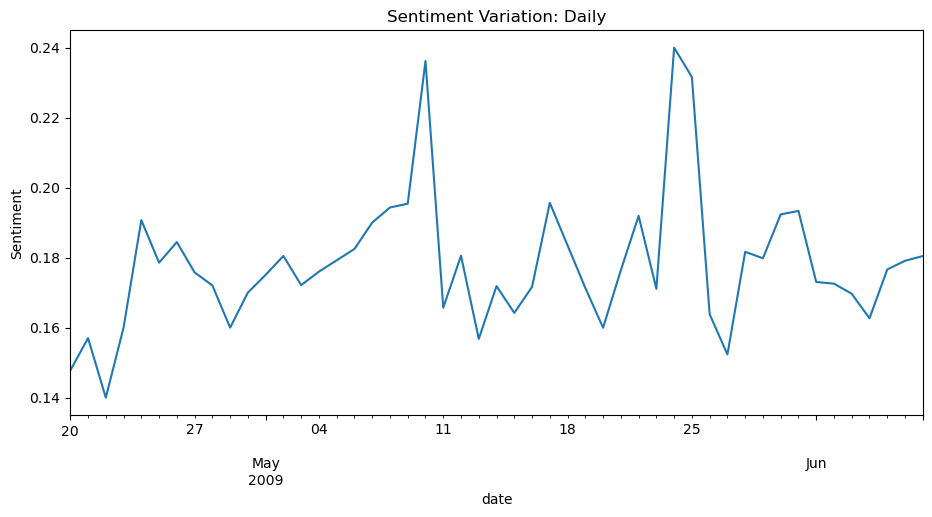

In [190]:
fig, ax = plt.subplots(figsize = (11, 5))
ax.set_xlabel('Date');  # Add an x-label to the axes.
ax.set_ylabel('Sentiment');  # Add a y-label to the axes.
ax.set_title("Sentiment Variation: Daily");  # Add a title to the graph.
dfTweetsPrep['sentiment_blob'].plot(ax = ax, label = 'Sentiment')
#ax.legend();


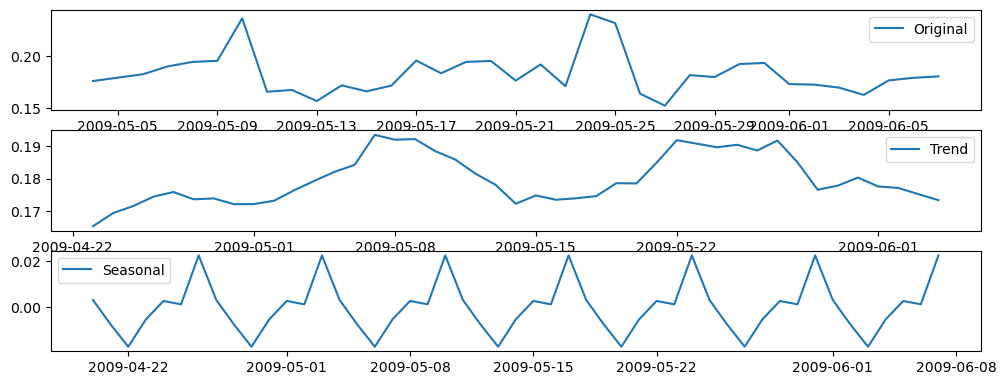

In [191]:
result = seasonal_decompose(dfTweetsPrep['sentiment_blob'], model = 'additive')

trend = result.trend
seasonal = result.seasonal

plt.figure(figsize = (12, 6))
plt.subplot(4, 1, 1)
plt.plot(dfTweetsPrep2['sentiment_blob'], label = 'Original')
plt.legend(loc = 'best')
plt.subplot(4, 1, 2)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(4, 1, 3)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')

# Modeling - Machine Learning

## Recursive autoregressive forecasting

In [53]:
#dfTweetsPredict7.loc[dfTweetsPredict7['week'] == 'Mon'].mean()[0]

In [54]:
#iTotal = len(dfTweetsPredict7.index)
#for i, row in dfTweetsPredict7.iterrows():
#    newdate = row["date"] + timedelta(days = iTotal)
#    newrow = pd.Series([newdate, row['week'], row['sentiment_blob']], index = dfTweetsPredict7.columns)
#    dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True) 
#    dfTweetsPredict7.append(row) 
    
#iTotal = len(dfTweetsPredict7.index)
#for i, row in dfTweetsPredict7.iterrows():
#    newdate = row["date"] + timedelta(days = iTotal)
#    newrow = pd.Series([newdate, row['week'], row['sentiment_blob']], index = dfTweetsPredict7.columns)
#    dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True) 
#    dfTweetsPredict7.append(row) 

#iTotal = len(dfTweetsPredict7.index)
#for i, row in dfTweetsPredict7.iterrows():
#    newdate = row["date"] + timedelta(days = iTotal)
#    newrow = pd.Series([newdate, row['week'], row['sentiment_blob']], index = dfTweetsPredict7.columns)
#    dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True) 
#    dfTweetsPredict7.append(row) 
    
#iTotal = len(dfTweetsPredict7.index)
#for i, row in dfTweetsPredict7.iterrows():
#    newdate = row["date"] + timedelta(days = iTotal)
#   newrow = pd.Series([newdate, row['week'], row['sentiment_blob']], index = dfTweetsPredict7.columns)
#    dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True) 
#    dfTweetsPredict7.append(row) 

In [137]:
dfTweetsPredict = dfTweetsPrep
dfTweetsPredict = dfTweetsPredict.rename(columns={'sentiment_blob': 'y'})
dfTweetsPredict = dfTweetsPredict.asfreq('1D')
dfTweetsPredict = dfTweetsPredict.sort_index()
dfTweetsPredict.head()



,week,y
date,,
2009-05-04,Mon,0.176000
2009-05-05,Tue,0.179233
2009-05-06,Wed,0.182467
2009-05-07,Thu,0.190012
2009-05-08,Fri,0.194323


In [138]:
print(f'Number of rows with missing values: {dfTweetsPredict.isnull().any(axis = 1).mean()}')

Number of rows with missing values: 0.0


In [139]:
# Verify that a temporary index is complete
# ==============================================================================
(dfTweetsPredict.index == pd.date_range(start = dfTweetsPredict.index.min(),
                             end = dfTweetsPredict.index.max(),
                             freq = dfTweetsPredict.index.freq)).all()

True

Train dates : 2009-05-04 00:00:00 --- 2009-05-30 00:00:00  (n = 27)
Test dates  : 2009-05-31 00:00:00 --- 2009-06-07 00:00:00  (n = 8)


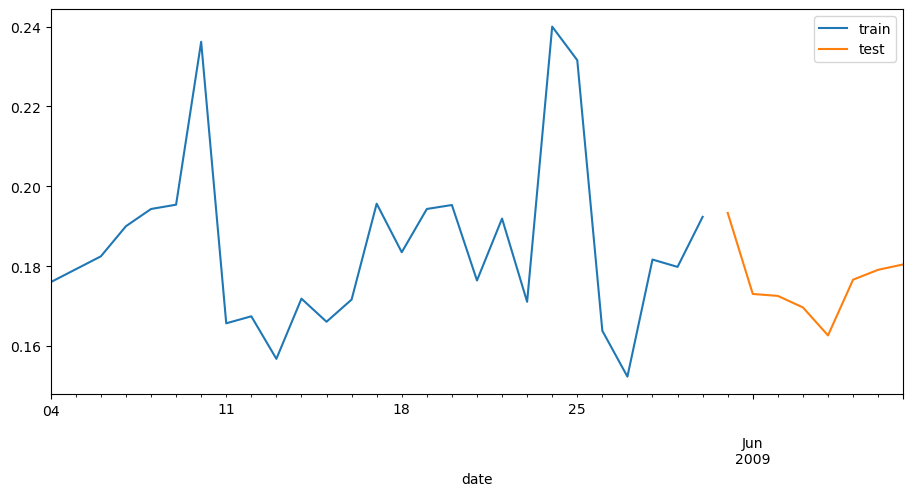

In [140]:
# Split data into train-test
# ==============================================================================
steps = 8
data_train = dfTweetsPredict[:-steps]
data_test  = dfTweetsPredict[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n = {len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n = {len(data_test)})")

fig, ax = plt.subplots(figsize = (11, 5))
data_train['y'].plot(ax = ax, label = 'train')
data_test['y'].plot(ax = ax, label = 'test')
ax.legend();

In [141]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state = 123),
                lags = 21
                )

forecaster.fit(y = data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] 
Transformer for y: None 
Transformer for exog: None 
Window size: 21 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2009-05-04 00:00:00'), Timestamp('2009-05-30 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-10-24 09:46:20 
Last fit date: 2023-10-24 09:

In [142]:
# Predictions
# ==============================================================================
steps = 8
predictions = forecaster.predict(steps = steps)
predictions.head(5)

2009-05-31    0.186266
2009-06-01    0.195094
2009-06-02    0.194262
2009-06-03    0.187940
2009-06-04    0.194738
Freq: D, Name: pred, dtype: float64

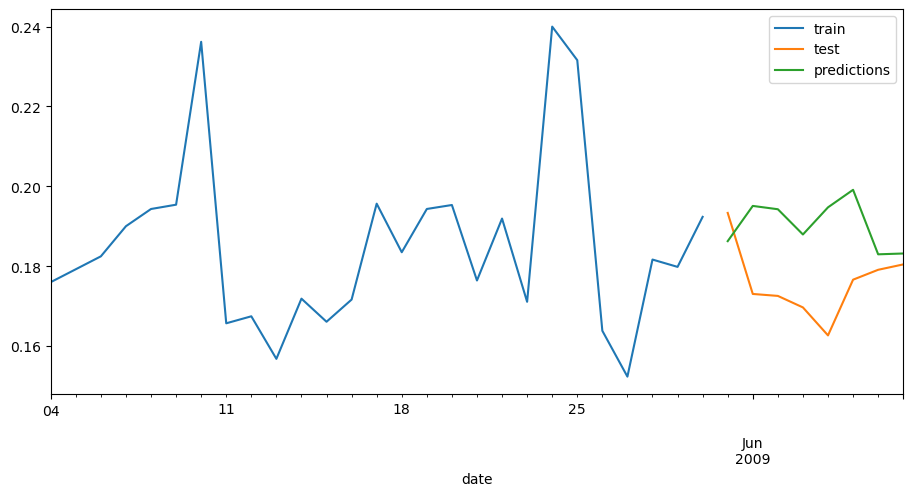

In [144]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize = (11, 5))
data_train['y'].plot(ax = ax, label = 'train')
data_test['y'].plot(ax = ax, label = 'test')
predictions.plot(ax = ax, label = 'predictions')
ax.legend();

In [145]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.0003623904294350714


In [146]:
# Save model
dump(forecaster, filename='forecaster.py')

['forecaster.py']

In [147]:
# Load model
forecaster_loaded = load('forecaster.py')

In [148]:
# Predict
forecaster_loaded.predict(steps = 30)

2009-05-31    0.186266
2009-06-01    0.195094
2009-06-02    0.194262
2009-06-03    0.187940
2009-06-04    0.194738
2009-06-05    0.199128
2009-06-06    0.182971
2009-06-07    0.183177
2009-06-08    0.181579
2009-06-09    0.182364
2009-06-10    0.185526
2009-06-11    0.176997
2009-06-12    0.184790
2009-06-13    0.185528
2009-06-14    0.181933
2009-06-15    0.189307
2009-06-16    0.191299
2009-06-17    0.185059
2009-06-18    0.189902
2009-06-19    0.181146
2009-06-20    0.185349
2009-06-21    0.182875
2009-06-22    0.179766
2009-06-23    0.180282
2009-06-24    0.183297
2009-06-25    0.180312
2009-06-26    0.185459
2009-06-27    0.183458
2009-06-28    0.184574
2009-06-29    0.184649
Freq: D, Name: pred, dtype: float64

## Autoregressive Integrated Moving Average (ARIMA)

In [282]:
dfArima = dfTweetsPredict

y = dfArima['y'].resample('1D').mean()

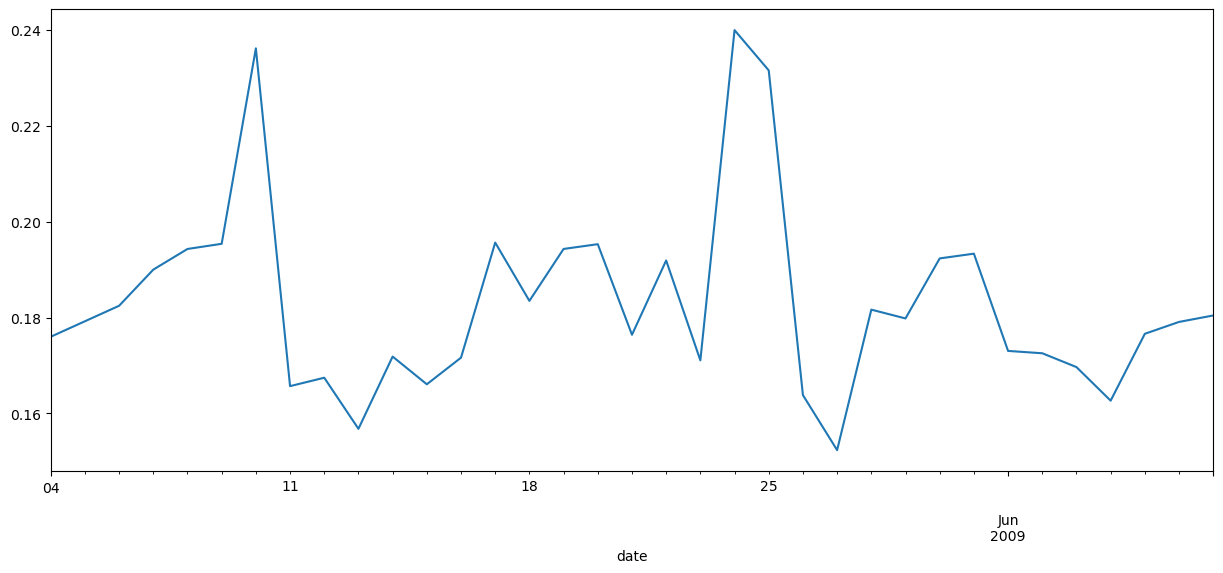

In [283]:
y.plot(figsize = (15, 6))
plt.show()

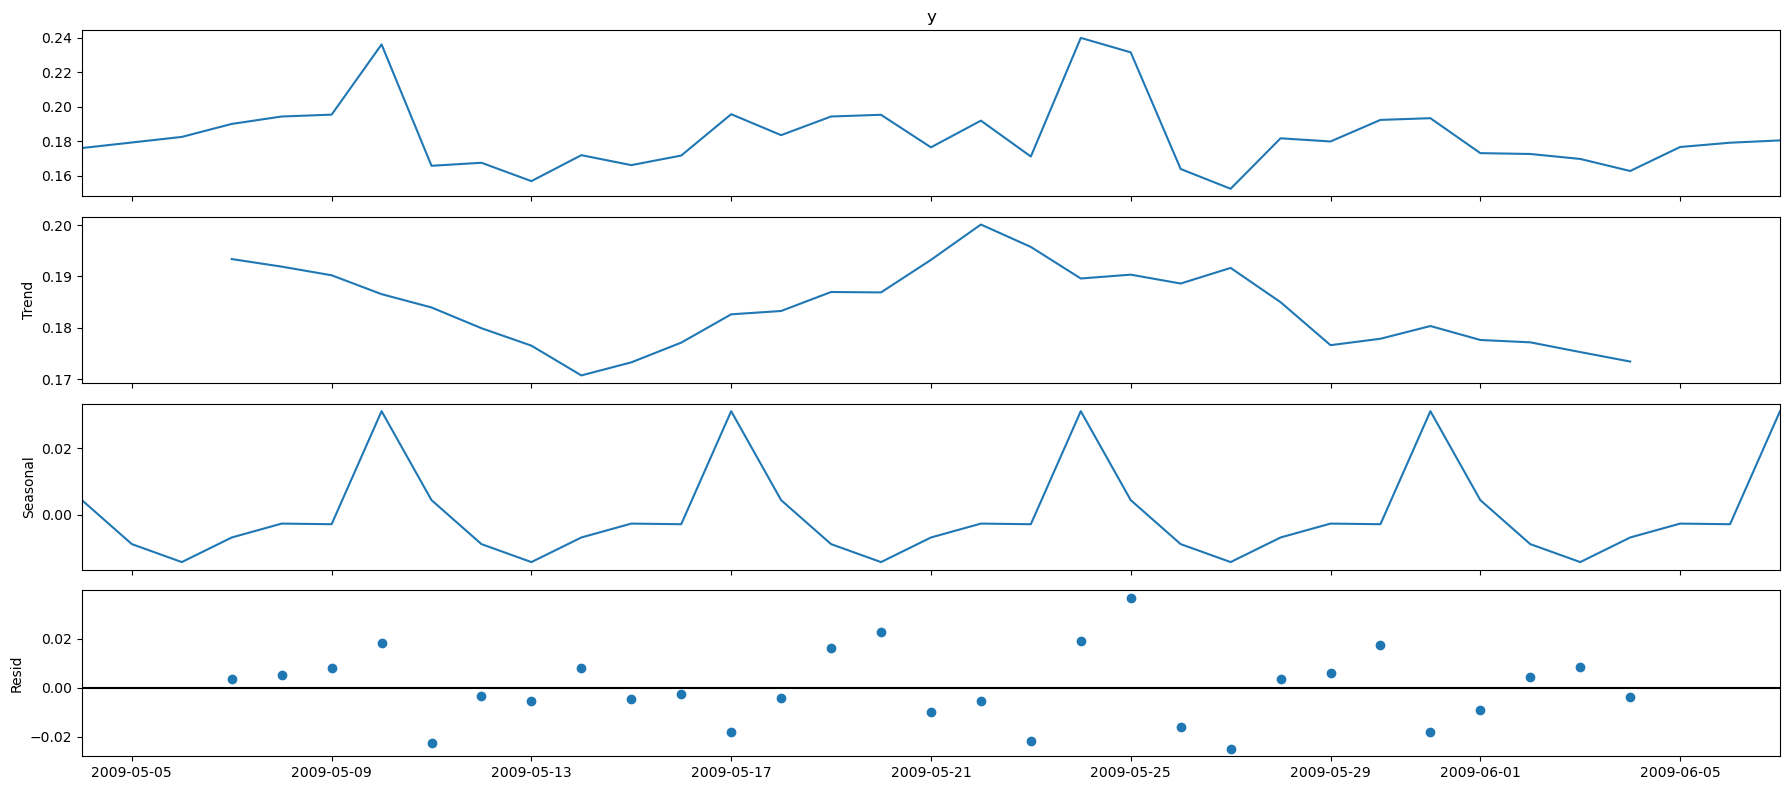

In [284]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model = 'additive')
fig = decomposition.plot()
plt.show()

In [285]:
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


The best AIC for Arima is the lowest number:

In [286]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.63657D-01    |proj g|=  1.32422D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2     17      1     0     0   1.716D-04  -2.637D-01
  F = -0.26365861808023411     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:-16.456103265616388
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variab

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.27470D+00    |proj g|=  2.31914D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      7     28      1     0     0   5.095D-04  -1.275D+00
  F =  -1.2747039271521590     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-87.22927490065112
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.04834D-01    |proj g|=  7.81330D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -6.80055D-01    |proj g|=  6.08980D+00

At iterate   10    f= -7.14986D-01    |proj g|=  1.62954D-02

At iterate   15    f= -7.15026D-01    |proj g|=  3.32548D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     37      1     0     0   3.325D-03  -7.150D-01
  F = -0.71502580535383486     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-46.05180637476844
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-91.09389239574861
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.65488D+01    |proj g|=  2.88362D+03

At iterate    5    f= -5.46197D-01    |proj g|=  2.82667D+00

At iterate   10    f= -1.07095D+00    |proj g|=  1.13219D+00

At iterate   15    f= -1.19054D+00    |proj g|=  3.46512D-01

At iterate   20    f= -1.25617D+00    |proj g|=  2.15964D+01

At iterate   25    f= -1.37673D+00    |proj g|=  5.94745D-01

At iterate   30    f= -1.37751D+00    |proj g|=  4.60955D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     21      1     0     0   8.892D-03  -8.031D-01
  F = -0.80312660358447541     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-52.218862250913276
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.04834D-01    |proj g|=  7.81330D-01

At iterate    5    f= -7.07321D-01    |proj g|=  4.05385D+00

At iterate   10    f= -7.18566D-01    |proj g|=  1.50438D-03

           *

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.38090D-01    |proj g|=  1.96916D+00

At iterate    5    f= -5.81377D-01    |proj g|=  1.85124D+00

At iterate   10    f= -6.24520D-01    |proj g|=  1.07465D+00

At iterate   15    f= -6.31214D-01    |proj g|=  1.40801D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     23      1     0     0   3.829D-07  -6.312D-01
  F = -0.63121366775751409     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0,

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


  ys=-4.899E-09  -gs= 2.244E-09 BFGS update SKIPPED

At iterate   15    f= -1.31857D+00    |proj g|=  1.32316D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     53      1     1     0   1.323D-03  -1.319D+00
  F =  -1.3185650247157346     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-88.29955173010141
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.59007D-01    |proj g|=  1.04557D+00


 This problem is unconstrained.



At iterate    5    f= -5.61564D-01    |proj g|=  1.23292D+00

At iterate   10    f= -6.08870D-01    |proj g|=  7.16647D-01

At iterate   15    f= -6.16161D-01    |proj g|=  5.07633D-01

At iterate   20    f= -6.21054D-01    |proj g|=  5.51851D+00

At iterate   25    f= -6.38254D-01    |proj g|=  3.42507D+00

At iterate   30    f= -6.41639D-01    |proj g|=  4.88492D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     62      1     0     0   2.911D-03  -6.416D-01
  F = -0.64163921816822866     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-38.9147452717


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-97.44642883896634
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.38090D-01    |proj g|=  1.96916D+00

At iterate    5    f= -1.06384D+00    |proj g|=  9.23653D+00

At iterate   10    f= -1.28691D+00    |proj g|=  1.20787D-01

At iterate   15    f= -1.29717D+00    |proj g|=  8.04228D-01

At iterate   20    f= -1.36818D+00    |proj g|=  9.42644D-01


 This problem is unconstrained.



At iterate   25    f= -1.37107D+00    |proj g|=  1.51888D+00

At iterate   30    f= -1.37787D+00    |proj g|=  6.98847D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     50      1     0     0   3.243D-03  -1.378D+00
  F =  -1.3779062963979318     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-88.45344074785523


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.35651D-01    |proj g|=  5.34410D+00

At iterate    5    f= -7.66363D-01    |proj g|=  5.36514D-01

At iterate   10    f= -8.04586D-01    |proj g|=  4.47153D+00

At iterate   15    f= -8.13247D-01    |proj g|=  7.14315D-02

At iterate   20    f= -8.14307D-01    |proj g|=  8.04900D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   25    f= -8.14524D-01    |proj g|=  4.80769D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     54      2     0     0   4.808D-04  -8.145D-01
  F = -0.81452447695117380     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-51.01671338658217
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.59007D-01    |proj g|=  3.01300D+01

At iterate    5    f= -5.87995D-01    |proj g|=  1.10604D+00

At iterate   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      8     55      2     1     0   5.218D-04  -1.153D+00
  F =  -1.1528106876369997     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:-78.69674813458998
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.10241D-01    |proj g|=  3.80773D-01



 This problem is unconstrained.


At iterate    5    f= -5.16411D-01    |proj g|=  1.44811D+00

At iterate   10    f= -6.03676D-01    |proj g|=  1.20072D+00

At iterate   15    f= -6.04599D-01    |proj g|=  7.49765D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     17     31      1     0     0   1.553D-03  -6.046D-01
  F = -0.60459867795660738     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:-38.32190745696251
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     49      1     0     0   1.708D-02  -1.402D+00
  F =  -1.4016592832617432     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:-92.11614982832202
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.85245D-01    |proj g|=  5.64231D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f= -6.08025D-01    |proj g|=  3.15878D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     72      2     0     0   2.025D-03  -6.080D-01
  F = -0.60802456739907929     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:-36.56171971793555
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.13771D+00    |proj g|=  2.32794D+00

At iterate    5    f= -2.14085D+00    |proj g|=  2.97887D+00

At iterate   10    f= -2.20475D+00    |proj g|=  7.36895D+00

At iterate   

 This problem is unconstrained.



At iterate   20    f= -1.37826D+00    |proj g|=  1.14392D-01

At iterate   25    f= -1.37826D+00    |proj g|=  1.85173D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     74      2     0     0   1.852D-03  -1.378D+00
  F =  -1.3782595849591872     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:-90.4781709471431
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.08562D+00    |proj g|=  1.39625D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.08692D+00    |proj g|=  4.19930D-02

At iterate   10    f= -1.08735D+00    |proj g|=  1.82449D+00

At iterate   15    f= -1.11747D+00    |proj g|=  3.95538D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     19     40      1     0     0   6.963D-03  -1.118D+00
  F =  -1.1175198728046858     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:-74.226391096328
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   10    f= -1.48189D+00    |proj g|=  5.91501D+00

At iterate   15    f= -1.50002D+00    |proj g|=  2.42187D-01

At iterate   20    f= -1.50431D+00    |proj g|=  4.08109D+00

At iterate   25    f= -1.52738D+00    |proj g|=  8.51451D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     35      1     0     0   2.535D-03  -1.527D+00
  F =  -1.5273792821394987     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:-100.91654974976491
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At 

 This problem is unconstrained.



At iterate   20    f= -1.38442D+00    |proj g|=  3.63023D-02

At iterate   25    f= -1.39775D+00    |proj g|=  2.28922D+00

At iterate   30    f= -1.39919D+00    |proj g|=  6.80149D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     63      1     0     0   2.006D-02  -1.399D+00
  F =  -1.3991903972695994     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:-89.94332780887196
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -7.01332D-01    |proj g|=  5.66333D-01

At iterate   10    f= -7.23304D-01    |proj g|=  1.07153D-01

At iterate   15    f= -7.23356D-01    |proj g|=  3.98022D-01

At iterate   20    f= -7.23698D-01    |proj g|=  4.79294D-01

At iterate   25    f= -7.24026D-01    |proj g|=  1.34767D-01

At iterate   30    f= -7.24100D-01    |proj g|=  5.22495D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     57      1     0     0   1.146D-03  -7.241D-01
  F = -0.72410062133855035     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:-44.6870434936

 This problem is unconstrained.



At iterate    5    f= -4.71812D-01    |proj g|=  2.17065D+00

At iterate   10    f= -5.57355D-01    |proj g|=  8.52946D-01

At iterate   15    f= -5.61256D-01    |proj g|=  1.47234D+00

At iterate   20    f= -5.66990D-01    |proj g|=  8.93434D-02

At iterate   25    f= -5.67001D-01    |proj g|=  2.91289D-02
  ys=-5.041E-10  -gs= 1.838E-09 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     57      1     1     0   4.576D-03  -5.670D-01
  F = -0.56700254444572551     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:-31.690178111200794
RUNN


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:-95.1304706465977
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.32836D+00    |proj g|=  7.09446D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     10      1     0     0   7.270D-03  -1.328D+00
  F =  -1.3283624106190621     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:-88.98536874333435
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =    

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     24      1     0     0   1.950D-02  -7.340D-01
  F = -0.73396742731642184     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:-45.37771991214953
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.14083D+00    |proj g|=  2.47876D+01

At iterate    5    f= -1.23283D+00    |proj g|=  3.79787D-01

At iterate   10    f= -1.29061D+00    |proj g|=  6.93059D+00

At iterate   

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     77      2     0     0   6.719D-04  -1.450D+00
  F =  -1.4501116117415676     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:-95.50781282190972
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.44243D+00    |proj g|=  1.15749D-01

At iterate    5    f= -1.44863D+00    |proj g|=  5.80141D-01

At iterate   10    f= -1.45389D+00    |proj g|=  1.02316D+00

At iterate   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f= -1.47061D+00    |proj g|=  2.18444D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     68      2     0     0   2.184D-03  -1.471D+00
  F =  -1.4706110797432339     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:-94.94277558202637
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.90923D-01    |proj g|=  5.96053D+00

At iterate    5    f= -7.38264D-01    |proj g|=  1.22498D-02

At iterate   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     80      2     1     0   7.092D-03  -7.385D-01
  F = -0.73851167712453314     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:-45.69581739871732
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.24141D-01    |proj g|=  1.39283D+00

At iterate    5    f= -6.48893D-01    |proj g|=  7.39499D+00

At iterate   10    f= -7.38473D-01    |proj g|=  1.36988D-01
  ys=-1.687E-0


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     96      2     2     0   7.559D-03  -7.385D-01
  F = -0.73847923410544147     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:-43.693546387380906
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.20783D+00    |proj g|=  3.01386D+00

At iterate    5    f= -2.20937D+00    |proj g|=  4.08394D-01

At iterate   10    f= -2.21514D+00    |proj g|=  5.29585D+00

At iterate  

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.40477D+00    |proj g|=  1.49179D-01

At iterate   10    f= -1.46987D+00    |proj g|=  7.99625D+00

At iterate   15    f= -1.48547D+00    |proj g|=  1.73499D-02

At iterate   20    f= -1.48584D+00    |proj g|=  9.20865D-01

At iterate   25    f= -1.48632D+00    |proj g|=  9.99128D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     40      1     0     0   1.795D-03  -1.486D+00
  F =  -1.4863235356978146     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:-96.04264749884702
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    5    f= -1.31932D+00    |proj g|=  1.27494D-01

At iterate   10    f= -1.31995D+00    |proj g|=  1.82385D-03

At iterate   15    f= -1.31996D+00    |proj g|=  6.09608D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     49      1     0     0   3.342D-04  -1.320D+00
  F =  -1.3199614791009486     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:-86.3973035370664
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate    5    f= -5.71652D-01    |proj g|=  3.80801D+00

At iterate   10    f= -6.27132D-01    |proj g|=  1.93249D+00

At iterate   15    f= -6.32060D-01    |proj g|=  9.33573D-02

At iterate   20    f= -6.35501D-01    |proj g|=  3.17538D-01

At iterate   25    f= -6.35817D-01    |proj g|=  1.38625D-01
  ys=-2.854E-07  -gs= 1.238E-07 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f= -6.35852D-01    |proj g|=  6.32171D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32    109      3     1     0   6.868D-03  -6.359D-01
  F = -0.63585222821444709     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:-36.5096559750113
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.14493D+00    |proj g|=  2.50180D+01

At iterate    5    f= -1.23691D+00    |proj g|=  3.62602D-01

At iterate   10    f= -1.28804D+00    |proj g|=  6.21142D+00

At iterate   1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f= -1.46508D+00    |proj g|=  7.38882D-02

At iterate   30    f= -1.46639D+00    |proj g|=  1.41296D+00

At iterate   35    f= -1.52937D+00    |proj g|=  6.77788D+00

At iterate   40    f= -1.54464D+00    |proj g|=  1.67857D+00

At iterate   45    f= -1.54854D+00    |proj g|=  4.09023D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     46     83      1     0     0   4.090D-03  -1.549D+00
  F =  -1.5485352999285507     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:-100.39747099499854
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f= -1.43887D+00    |proj g|=  1.35613D+00

At iterate   20    f= -1.48718D+00    |proj g|=  1.95981D+00

At iterate   25    f= -1.49050D+00    |proj g|=  4.33938D-02

At iterate   30    f= -1.49181D+00    |proj g|=  1.32602D+00

At iterate   35    f= -1.50700D+00    |proj g|=  3.89392D-01

At iterate   40    f= -1.50902D+00    |proj g|=  7.76943D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     73      1     0     0   2.046D-02  -1.509D+00
  F =  -1.5091902201204423     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:-95.64331540843096
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.63485D-01    |proj g|=  4.24913D+00

At iterate    5    f= -6.84845D-01    |proj g|=  1.20265D+00

At iterate   10    f= -7.24632D-01    |proj g|=  2.88409D-01

At iterate   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37    111      2     1     0   7.407D-03  -7.442D-01
  F = -0.74417376451536998     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:-44.0921635160759
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.60550D-01    |proj g|=  4.26288D+01


 This problem is unconstrained.



At iterate    5    f= -5.90141D-01    |proj g|=  2.16899D+00

At iterate   10    f= -6.40267D-01    |proj g|=  4.54259D-01

At iterate   15    f= -6.40519D-01    |proj g|=  2.77410D-02

At iterate   20    f= -6.40988D-01    |proj g|=  2.09346D-02

At iterate   25    f= -6.57959D-01    |proj g|=  1.67845D+00

At iterate   30    f= -6.62523D-01    |proj g|=  2.40107D-02

At iterate   35    f= -6.62523D-01    |proj g|=  1.91888D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     74      1     0     0   1.919D-03  -6.625D-01
  F = -0.66252342815342813     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     41      1     0     0   1.211D-04  -1.388D+00
  F =  -1.3875258644089308     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:-91.12681050862516
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.15286D+00    |proj g|=  4.10658D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   10    f= -6.43233D-01    |proj g|=  8.64197D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     25      1     0     0   7.190D-02  -6.443D-01
  F = -0.64430036292229942     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:-39.10102540456096
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.37830D+00    |proj g|=  8.09367D-01

At iterate    5    f= -1.38325D+00    |proj g|=  2.71575D+00

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.38281D+00    |proj g|=  1.67037D+00

At iterate   10    f= -1.38653D+00    |proj g|=  1.56229D-02

At iterate   15    f= -1.38658D+00    |proj g|=  1.50561D-01

At iterate   20    f= -1.38668D+00    |proj g|=  3.59448D-02

At iterate   25    f= -1.38670D+00    |proj g|=  1.37804D-01

At iterate   30    f= -1.39084D+00    |proj g|=  1.45838D+00

At iterate   35    f= -1.39685D+00    |proj g|=  2.53667D-01

At iterate   40    f= -1.39716D+00    |proj g|=  2.36303D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     41     54      1     0     0   2.804D-03  -1.397D+00
  F =  -1.39715603204

 This problem is unconstrained.



At iterate   10    f= -6.52117D-01    |proj g|=  5.91298D+00

At iterate   15    f= -6.59170D-01    |proj g|=  2.91622D-02

At iterate   20    f= -6.59173D-01    |proj g|=  2.14504D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     49      1     0     0   4.333D-03  -6.592D-01
  F = -0.65917343739552281     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:-40.14214061768659
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     36      1     0     0   1.169D-02  -6.592D-01
  F = -0.65917299782977301     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:-38.14210984808411
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.17333D+00    |proj g|=  7.05414D+00

At iterate    5    f= -2.18199D+00    |proj g|=  7.35974D-01

At iterate   10    f= -2.20518D+00    |proj g|=  1.27249D+01

At iterate   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.35790D+00    |proj g|=  4.20224D-01

At iterate   10    f= -1.37097D+00    |proj g|=  7.88119D+00

At iterate   15    f= -1.39265D+00    |proj g|=  2.02183D-02

At iterate   20    f= -1.39271D+00    |proj g|=  6.07981D-01

At iterate   25    f= -1.39388D+00    |proj g|=  2.49417D-01

At iterate   30    f= -1.39395D+00    |proj g|=  4.28577D-03

At iterate   35    f= -1.39395D+00    |proj g|=  1.10245D-01

At iterate   40    f= -1.39398D+00    |proj g|=  1.35008D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     44     52      1     0     0   1.187D-03  -1.394D+00
  F =  -1.39398023522

 This problem is unconstrained.



At iterate   25    f= -1.16087D+00    |proj g|=  6.07759D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     63      1     0     0   2.862D-03  -1.161D+00
  F =  -1.1608711158590201     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:-75.2609781101314
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.50425D-01    |proj g|=  1.25046D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -5.53608D-01    |proj g|=  2.84595D+00

At iterate   10    f= -5.59090D-01    |proj g|=  2.45509D-02
  ys=-2.154E-07  -gs= 1.316E-06 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f= -5.59597D-01    |proj g|=  7.48022D-01

At iterate   20    f= -5.63637D-01    |proj g|=  2.22442D-01

At iterate   25    f= -5.74713D-01    |proj g|=  6.41407D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29    141      4     1     0   1.763D-02  -5.747D-01
  F = -0.57472225113080322     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:-32.23055757915621
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.41652D+00    |proj g|=  5.29229D+00

At iterate    5    f= -1.42399D+00    |proj g|=  3.35050D-01

At iterate   10    f= -1.43410D+00    |proj g|=  7.38582D+00

At iterate   

 This problem is unconstrained.



At iterate    5    f= -1.35792D+00    |proj g|=  4.65664D-01

At iterate   10    f= -1.37183D+00    |proj g|=  7.27885D+00

At iterate   15    f= -1.38615D+00    |proj g|=  7.07753D-02

At iterate   20    f= -1.38724D+00    |proj g|=  2.02057D+00

At iterate   25    f= -1.39224D+00    |proj g|=  3.33699D-01

At iterate   30    f= -1.39497D+00    |proj g|=  3.21992D-01

At iterate   35    f= -1.39557D+00    |proj g|=  6.53689D-01

At iterate   40    f= -1.39862D+00    |proj g|=  2.10453D-01

At iterate   45    f= -1.40272D+00    |proj g|=  1.45123D+00

At iterate   50    f= -1.40523D+00    |proj g|=  1.53637D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f= -6.46969D-01    |proj g|=  2.02177D-01

At iterate   20    f= -6.47292D-01    |proj g|=  6.64545D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f= -6.47293D-01    |proj g|=  1.62951D-03

At iterate   30    f= -6.54196D-01    |proj g|=  2.43512D+00

At iterate   35    f= -6.58471D-01    |proj g|=  1.59390D-01

At iterate   40    f= -6.58542D-01    |proj g|=  1.22247D-01

At iterate   45    f= -6.59000D-01    |proj g|=  4.79949D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     48    103      2     0     0   4.491D-02  -6.590D-01
  F = -0.65902779071868822     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:-38.13194535030818
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.



At iterate    5    f= -4.54997D-01    |proj g|=  5.35831D-01

At iterate   10    f= -5.23628D-01    |proj g|=  3.95368D+00

At iterate   15    f= -5.66842D-01    |proj g|=  3.33946D-01

At iterate   20    f= -5.66943D-01    |proj g|=  2.10882D-02

At iterate   25    f= -5.67714D-01    |proj g|=  3.61228D-02

At iterate   30    f= -5.67732D-01    |proj g|=  5.55222D-02

At iterate   35    f= -5.67741D-01    |proj g|=  3.77322D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     76      2     0     0   8.844D-04  -5.677D-01
  F = -0.56774123818154665     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


<b>Best Arima fit: </b>
<br/>
<br/>
With april data:
<br/>
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:-229.44581009804904
<br/>
<br/>
without april data:
<br/>
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-148.4272944748092


In [287]:
if bWithAprilData :
    ### ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-148.4272944748092
    ### ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:-152.11004169878163
    # ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:-229.44581009804904    
    # ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:-150.7230397257889    
    # ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:-154.62731728297405
    mod = sm.tsa.statespace.SARIMAX(y,
                            order = (0, 1, 0),
                            seasonal_order = (0, 0, 0, 12),
                            enforce_stationarity = False,
                            enforce_invertibility = False)
    
else:
    
    mod = sm.tsa.statespace.SARIMAX(y,
                            order = (0, 1, 0),
                            seasonal_order = (0, 0, 0, 12),
                            enforce_stationarity = False,
                            enforce_invertibility = False)



    
results = mod.fit()
print(results.summary().tables[1])


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.14814D+00    |proj g|=  2.33605D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3     17      1     0     0   4.652D-03  -2.149D+00
  F =  -2.1489613496401314     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0006   9.67e-05    

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [288]:
results = mod.fit()
print(results.summary().tables[1])

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.14814D+00    |proj g|=  2.33605D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3     17      1     0     0   4.652D-03  -2.149D+00
  F =  -2.1489613496401314     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0006   9.67e-05    

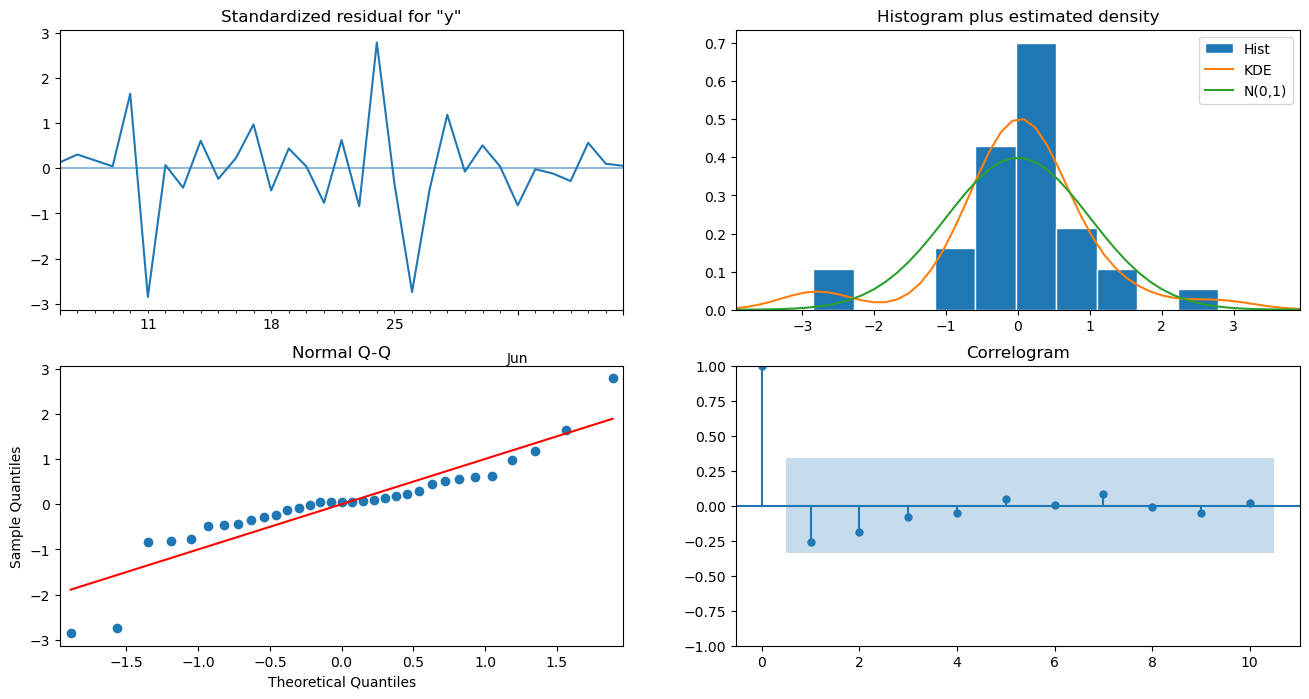

In [289]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

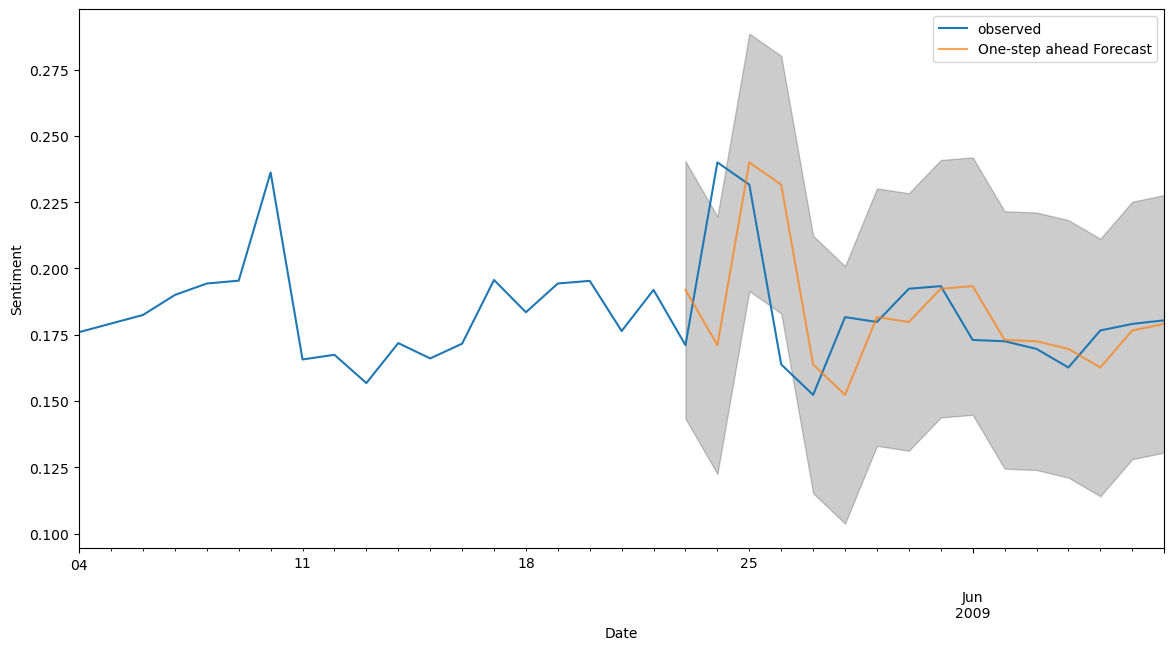

In [290]:
pred = results.get_prediction(start = pd.to_datetime('2009-05-23'), dynamic = False)
pred_ci = pred.conf_int()
ax = y.plot(label = 'observed')
pred.predicted_mean.plot(ax = ax, label = 'One-step ahead Forecast', alpha = 0.7, figsize = (14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha = 0.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sentiment')
plt.legend()
plt.show()

In [296]:
y_forecasted = pred.predicted_mean
y_truth = y['2009-05-04':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.0


In [300]:
pred

In [297]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 0.03


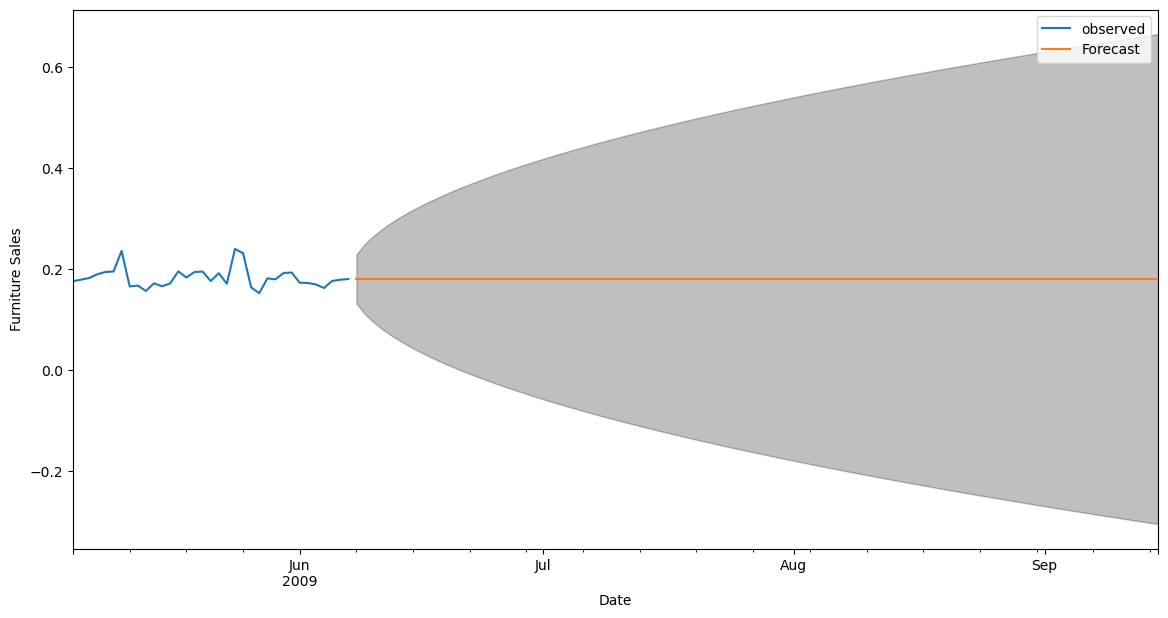

In [299]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(net_df.index[-600:], net_df['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Netflix Stock Price')
plt.legend()
plt.grid(True)
plt.savefig('arima_model.pdf')

plt.show()